In [15]:
from models import Models
from Data_preprocessing import split_60 ,split_train_val_test ,load_data
from utils import save_data, split_train_test ,plot_scatter_hr ,plot_loss ,calculate_loss_hr
from custom_callbacks import EarlyStoppingIncreasingValLoss

from sklearn.preprocessing import MinMaxScaler
import joblib

import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt


from tensorflow.keras.models import save_model

from keras.optimizers import RMSprop ,Adam ,SGD ,Adagrad
from keras.callbacks import EarlyStopping

import json
import os
import time

import tensorflow as tf
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings("ignore")

In [16]:
#model_name = 'model2_hr'
NUM_EPOCH = 3
scaled = False

# lr = 5e-4
# optimizer = RMSprop(learning_rate=lr)
# loss = "mse"

In [17]:
df , ratio = load_data()
df

(5439, 1813, 1813)


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,hr,calculated_hr,DBP,SBP
0,0.022165,0.008058,-0.005694,-0.018277,-0.028401,-0.034445,-0.034832,-0.028548,-0.015653,0.002471,...,0.006408,-0.014542,-0.033742,-0.049071,-0.058827,-0.061907,70,99.23,75,111
1,0.002396,-0.001148,-0.004544,-0.007492,-0.009561,-0.010251,-0.009101,-0.005841,-0.000541,0.006277,...,0.023915,0.031500,0.035881,0.036621,0.033664,0.027309,85,86.31,86,133
2,-0.007708,-0.005857,-0.004098,-0.002622,-0.001656,-0.001300,-0.001325,-0.001099,0.000269,0.003553,...,-0.055547,-0.063149,-0.066136,-0.062301,-0.050670,-0.031967,59,57.83,87,139
3,-0.010544,-0.005010,0.000461,0.005682,0.010287,0.013727,0.015341,0.014503,0.010822,0.004327,...,-0.027160,-0.043717,-0.057046,-0.066155,-0.070509,-0.070022,86,68.22,80,146
4,-0.007411,-0.007268,-0.007012,-0.006467,-0.005435,-0.003734,-0.001218,0.002173,0.006360,0.011074,...,-0.023944,-0.009014,0.006739,0.022151,0.036009,0.047166,85,72.06,80,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9060,0.028062,0.013806,-0.000827,-0.014660,-0.026783,-0.036512,-0.043327,-0.046852,-0.046867,-0.043359,...,-0.031265,-0.024912,-0.017063,-0.008171,0.001152,0.010138,82,82.40,79,133
9061,0.054225,0.071998,0.084893,0.091340,0.090327,0.081546,0.065480,0.043417,0.017377,-0.010103,...,0.020310,0.008572,-0.002583,-0.012376,-0.020267,-0.026010,86,77.07,80,146
9062,0.045568,0.033181,0.017340,-0.000325,-0.017933,-0.033597,-0.045684,-0.052995,-0.054832,-0.050976,...,0.068069,0.077176,0.078598,0.072051,0.058184,0.038529,93,90.76,81,118
9063,-0.108834,-0.099573,-0.085189,-0.067508,-0.048111,-0.028148,-0.008312,0.011064,0.029816,0.047741,...,-0.067566,-0.058927,-0.048947,-0.037186,-0.023145,-0.006584,68,69.99,84,148


In [18]:
df_input = df.drop(['DBP','SBP','hr','calculated_hr'], axis=1)
df_target = df[['hr']]

display(df_target)

scaler = MinMaxScaler()
scaled_df_target = scaler.fit_transform(df_target)
print(df_input.shape)
print(scaled_df_target.shape)

if scaled == True:
    df_target = scaled_df_target
        
X_train, y_train, X_val, y_val, X_test, y_test = split_train_test(df_input ,df_target ,ratio)
    

,hr
0,70
1,85
2,59
3,86
4,85
...,...
9060,82
9061,86
9062,93
9063,68


(9065, 60)
(9065, 1)


In [19]:
import sklearn

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [20]:
"""models = [LinearRegression(), XGBRegressor(), SVR(kernel='rbf', C=1.0, epsilon=0.1), RandomForestRegressor()]
model_names = ['Linear Regression', 'XGB Regressor', 'SVR', 'Random Forest Regressor']

for model, model_name in zip(models, model_names):
    history=model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    print(f"{model_name} - Training set - MSE: {train_mse}, MAE: {train_mae}")

    y_pred_test = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    print(f"{model_name} - Test set - MSE: {test_mse}, MAE: {test_mae}")"""

'models = [LinearRegression(), XGBRegressor(), SVR(kernel=\'rbf\', C=1.0, epsilon=0.1), RandomForestRegressor()]\nmodel_names = [\'Linear Regression\', \'XGB Regressor\', \'SVR\', \'Random Forest Regressor\']\n\nfor model, model_name in zip(models, model_names):\n    history=model.fit(X_train, y_train)\n\n    y_pred_train = model.predict(X_train)\n    train_mse = mean_squared_error(y_train, y_pred_train)\n    train_mae = mean_absolute_error(y_train, y_pred_train)\n    print(f"{model_name} - Training set - MSE: {train_mse}, MAE: {train_mae}")\n\n    y_pred_test = model.predict(X_test)\n    test_mse = mean_squared_error(y_test, y_pred_test)\n    test_mae = mean_absolute_error(y_test, y_pred_test)\n    print(f"{model_name} - Test set - MSE: {test_mse}, MAE: {test_mae}")'

Linear Regression - Validation set - MSE: 137.13538520924985, MAE: 9.441905393987268
Linear Regression - Test set - MSE: 134.9532574719941, MAE: 9.489312832816983
XGB Regressor - Validation set - MSE: 107.51971449358398, MAE: 8.278445231736988
XGB Regressor - Test set - MSE: 111.51581230791534, MAE: 8.496271555290917
SVR - Validation set - MSE: 109.31213975148198, MAE: 8.2164613650781
SVR - Test set - MSE: 113.60996745609293, MAE: 8.443786881743474
Random Forest Regressor - Validation set - MSE: 117.18437066926282, MAE: 8.66626261179576
Random Forest Regressor - Test set - MSE: 120.26745930313318, MAE: 8.908677902796475


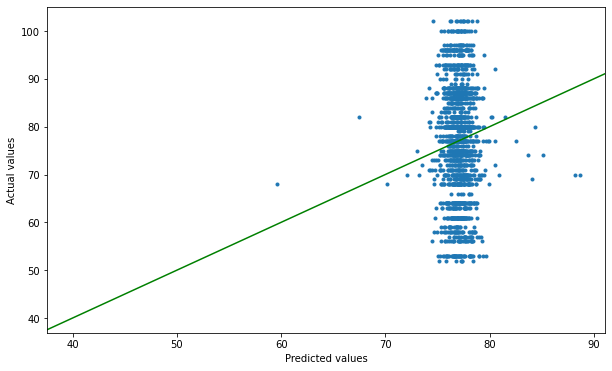

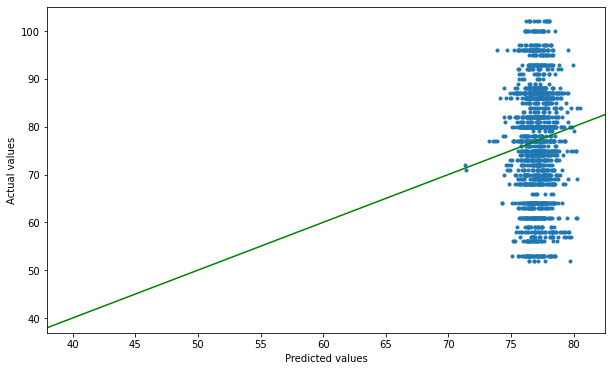

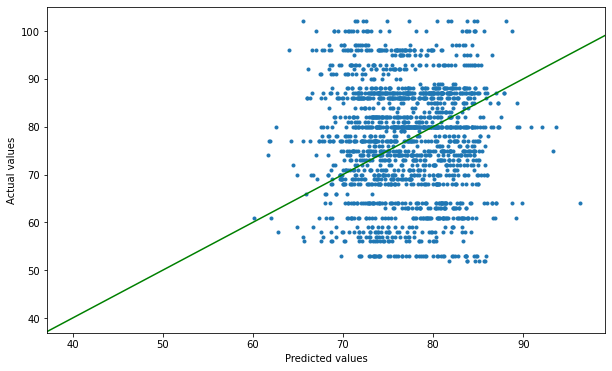

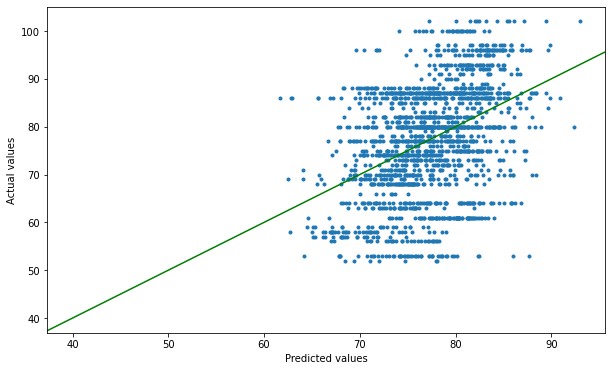

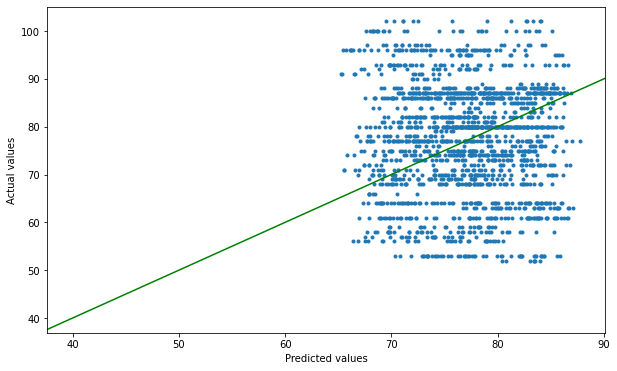

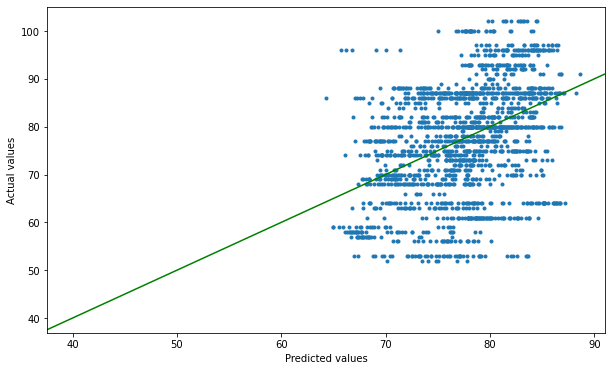

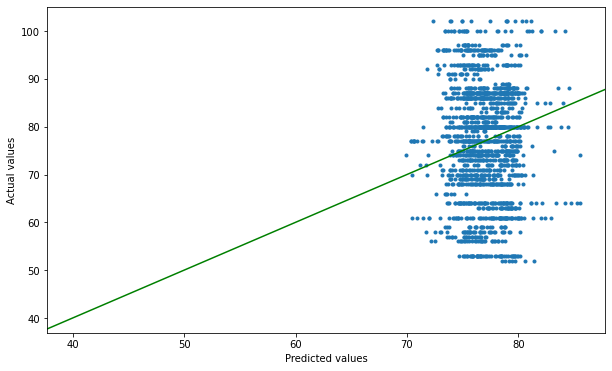

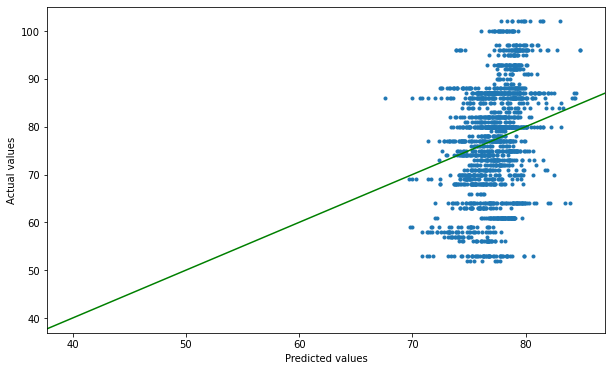

In [23]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np

models = [
    LinearRegression(),
    XGBRegressor(),
    SVR(kernel='rbf', C=1.0, epsilon=0.1),
    RandomForestRegressor()
]

model_names = [
    'Linear Regression',
    'XGB Regressor',
    'SVR',
    'Random Forest Regressor'
]

param_grids = [
    {},
    {'n_estimators': [100, 200],'max_depth': [3, 6],'learning_rate': [0.1, 0.01]}, 
    {'C': [0.1, 1, 10],'epsilon': [0.1, 0.01]}, 
    {'n_estimators': [100, 200],'max_depth': [3, 6]}]

for model, model_name, param_grid in zip(models, model_names, param_grids):
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_

    model.fit(X_train, y_train)
    
    result_name = f'{model_name}'
    folder_path = f'./hr_ML_optimization_results/{result_name}'
    os.makedirs(folder_path)

    #results = model.evaluate(X_test, y_test)
    filename = f'./ML_models/{model_name}'
    joblib.dump(model, filename)
    
    y_pred_val = model.predict(X_val)
    
    y_predicted_df = pd.DataFrame(y_val)
    y_val_predicted_df = pd.DataFrame(y_pred_val)
    y_test_df = pd.DataFrame(y_test)
    
    val_mse = mean_squared_error(y_val, y_pred_val)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    print(f"{model_name} - Validation set - MSE: {val_mse}, MAE: {val_mae}")
    
    plot_scatter_hr(y_val_predicted_df, y_test_df ,folder_path)
    
    y_pred_test = model.predict(X_test)
    
    y_test_predicted_dft = pd.DataFrame(y_pred_test)
    
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    print(f"{model_name} - Test set - MSE: {test_mse}, MAE: {test_mae}")
    
    plot_scatter_hr(y_test_predicted_dft, y_test_df ,folder_path)
    
    out_dict = {
        'model_name':[model_name],
        'val_mse':[val_mse],
        'val_mae':[val_mae],
        'test_mse':[test_mse],
        'test_mae':[test_mae],
        'time':[time.time()]

    }

    save_data(out_dict, 'sheets/hr_ML_model_optimizing.csv')



In [ ]:
y_predicted_df

In [27]:
X_val.shape

(1813, 60)